In [24]:
#pip install xgboost shap

In [180]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
#Imports génériques
import numpy as np
import pandas as pd
import gc
import time
import shutil
from contextlib import contextmanager

#Modélisation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#Mise au point modélisation
from imblearn.over_sampling import SMOTE
from sklearn import set_config
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, make_scorer,
                             precision_recall_curve, PrecisionRecallDisplay)
from sklearn.model_selection import (learning_curve, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
import joblib
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

#DataViz
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
pd.set_option('display.max_row', 800)
pd.set_option("display.max_columns", None)
set_config(display="text")
sns.set_theme(style='whitegrid', palette='pastel')

In [94]:
randomState = 42
data = "Data/Source/"
mlflow_uri = "http://10.0.50.72:5000"
FichierClient= 'Data/Db/ClientDatabase.csv'
FichierClientApi= 'Api/Data/Db/ClientDatabase.csv'
mlflow.set_tracking_uri(mlflow_uri)

In [96]:
@contextmanager
def timer(title):
    """Timer"""
    t0 = time.time()
    yield
    print("{} - {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    """One-hot encoding for categorical columns with get_dummies"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows = None, nan_as_category = False):
    """Preprocess application_train.csv and application_test.csv"""
    # Read data and merge
    df = pd.read_csv(data+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(data+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

def bureau_and_balance(num_rows = None, nan_as_category = True):
    """Preprocess bureau.csv and bureau_balance.csv"""
    bureau = pd.read_csv(data+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(data+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

def previous_applications(num_rows = None, nan_as_category = True):
    """Preprocess previous_applications.csv"""
    prev = pd.read_csv(data+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

def pos_cash(num_rows = None, nan_as_category = True):
    """Preprocess POS_CASH_balance.csv"""
    pos = pd.read_csv(data+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

def installments_payments(num_rows = None, nan_as_category = True):
    """Preprocess installments_payments.csv"""
    ins = pd.read_csv(data+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

def credit_card_balance(num_rows = None, nan_as_category = True):
    """Preprocess credit_card_balance.csv"""
    cc = pd.read_csv(data+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug = False):
    """Fonction principale appelant les fonctions précédentes"""
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print(f"Final DataFrame shape: {df.shape}")
    return df

In [66]:
with timer(45*"-"+"\nPréprocessing / Feature engineering"):
    df_data = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - 19s
Previous applications df shape: (338857, 249)
Process previous_applications - 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - 13s
Installments payments df shape: (339587, 26)
Process installments payments - 25s
Credit card balance df shape: (103558, 141)
Process credit card balance - 17s
Final DataFrame shape: (356251, 797)
---------------------------------------------
Préprocessing / Feature engineering - 101s


In [85]:
df_data.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [182]:
def repartitionCibles(dataset, titre=""):
    """  """
    if not isinstance(dataset, pd.DataFrame):
        dataset = pd.DataFrame(dataset, columns = ['TARGET'])
    if 'TARGET' in dataset.columns:
        values = dataset['TARGET'].value_counts()
        val1 = values[1] / (values[0]+values[1])
        print("---- Ratio des valeurs cibles " + titre + "----")
        print(f"valeurs positives {val1:.1%} ({values[1]})")
        print(f"valeurs négatives {(1-val1):.1%} ({values[0]})")
    else:
        print("Le dataset fourni ne comporte pas de cibles")

def filtreOuliers(dataset):
    """  """
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    return dataset

def séparationTrain(dataset):
    train = dataset[dataset['TARGET'].notnull()]
    test = dataset[dataset['TARGET'].isnull()]
    saveFichierClient(test)
    return train

def splitTrainTest(dataset):
    """  """
    dataset = dataset.drop(columns=['SK_ID_CURR'])
    target = dataset['TARGET']
    train, test = train_test_split(dataset, test_size=0.2, 
                                   stratify=target, random_state=randomState)
    print(f"Données train shape: {train.shape}")
    print(f"Données test shape: {test.shape}")
    X_train = train.drop(columns=['TARGET'])
    X_test = test.drop(columns=['TARGET'])
    y_train = train['TARGET']
    y_test = test['TARGET']
    return X_train, X_test, y_train, y_test

def equilibrageDonnées(dataset, labels):
    """  """
    imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
    dataset = imputer.fit_transform(dataset)
    smt = SMOTE(random_state=randomState)
    dataset_res, labels_res = smt.fit_resample(dataset, labels)
    return dataset_res, labels_res

def saveFichierClient(dataset):
    """  """
    with timer("sauvegarde des données application"):
        df_clients=dataset.sort_values(by='SK_ID_CURR', ascending=True)
        df_clients.to_csv(FichierClient, sep=',', index=False)
    with timer("sauvegarde échantillon des données"):
        sample=df_clients.sample(50).sort_values(by='SK_ID_CURR', ascending=True)
        sample.to_csv(FichierClientApi, sep=',', index=False)

def traitementDonnées(dataset):
    """  """
    repartitionCibles(dataset, 'pre traitement ')
    with timer("filtre ouliers"):
        dataset = filtreOuliers(dataset)
    with timer("séparation des données d\'entrainement'"):
        train = séparationTrain(dataset)
    with timer("split Train/Test des données"):
        X_train, X_test, y_train, y_test = splitTrainTest(train)
    with timer("équilibrage des données"):
        X_train, y_train = equilibrageDonnées(X_train, y_train)
    repartitionCibles(y_train, 'set de train ')
    repartitionCibles(y_test, 'set de test ')
    return X_train, X_test, y_train, y_test

with timer(45*"-"+"\nProcessing "):
        X_train, X_test, y_train, y_test = traitementDonnées(df_data)

---- Ratio des valeurs cibles pre traitement ----
valeurs positives 8.1% (24825)
valeurs négatives 91.9% (282682)
filtre ouliers - 5s
sauvegarde des données application - 247s
sauvegarde échantillon des données - 0s
séparation des données d'entrainement' - 248s
Données train shape: (246005, 796)
Données test shape: (61502, 796)
split Train/Test des données - 2s
équilibrage des données - 34s
---- Ratio des valeurs cibles set de train ----
valeurs positives 50.0% (226145)
valeurs négatives 50.0% (226145)
---- Ratio des valeurs cibles set de test ----
valeurs positives 8.1% (4965)
valeurs négatives 91.9% (56537)
---------------------------------------------
Processing  - 290s


In [183]:
def matriceConfusion(y_test, y_pred, nom=""):
    """
    Calcule les valeurs et pourcentages et
    Affiche une matrice de confusion avec 
    les données envoyées
    _______________entrées_______________
    y_reel : array des valeurs réélles
    y_pred : array des valeurs prédites
    titre  : titre affiché sur le graphe
    _______________sorties_______________
    affiche le graphe de la matrice de confusion
    """
    plt.figure(figsize=(5, 4))
    matrice = confusion_matrix(y_test, y_pred)
    noms_groupes = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
    vals_groupes = ["{0:0.0f}".format(value) for value in matrice.flatten()]
    perc_groupes = ["{0:.2%}".format(value) for value in matrice.flatten()/np.sum(matrice)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(noms_groupes,vals_groupes,perc_groupes)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrice,
                annot=labels,
                fmt='',
                cmap=plt.cm.YlOrBr,
                cbar=False)
    plt.title(f'Matrice de confusion: {nom}', pad=20)
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()

def scoreAuc(y_test, y_pred_prob, nom=""):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.show()

def scoreMet(y_test, y_pred, nom=""):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    score = (10*fn+fp)
    return score

def evalModel(model, nom=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    matriceConfusion(y_test, y_pred, nom="")
    scoreAuc(y_test, y_pred_prob)
    scoreMetier = scoreMet(y_test, y_pred, nom="")
    print(classification_report(y_test, y_pred))
    print(f"Score Metier: {scoreMetier}")
    return scoreMetier

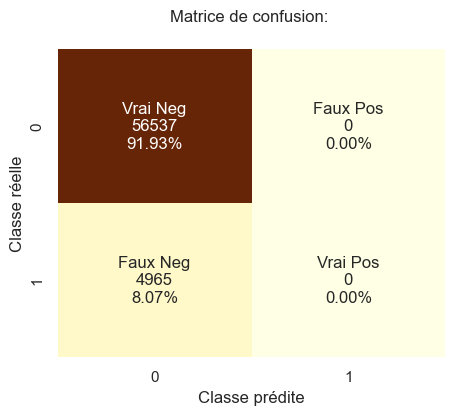

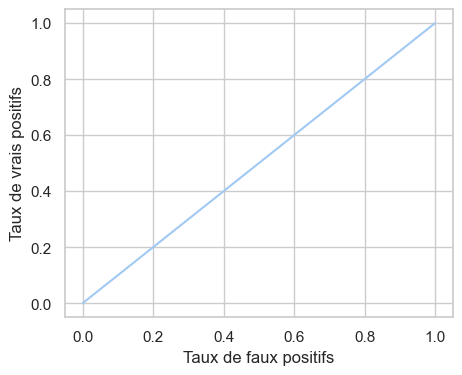

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

Score Metier: 49650


49650

In [184]:
estimator = DummyClassifier(strategy='most_frequent')
evalModel(estimator)